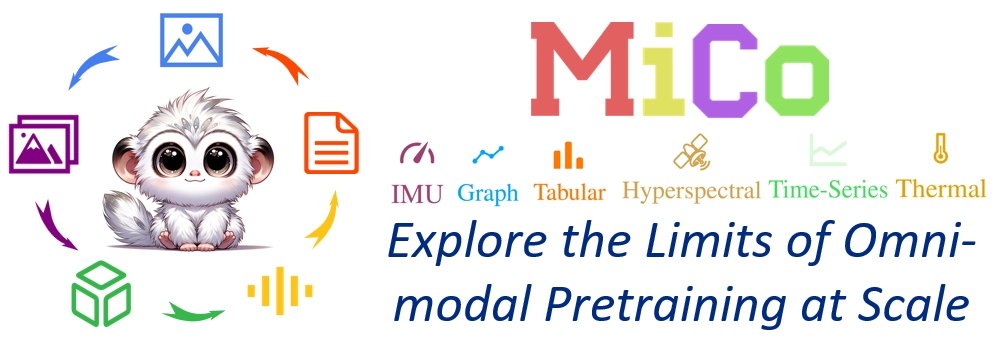
# Inference on [MiCo](https://github.com/invictus717/MiCo) 

## Paper: [Explore the Limits of Omni-modal Pretraining at Scale](https://arxiv.org/abs/2406.09412)
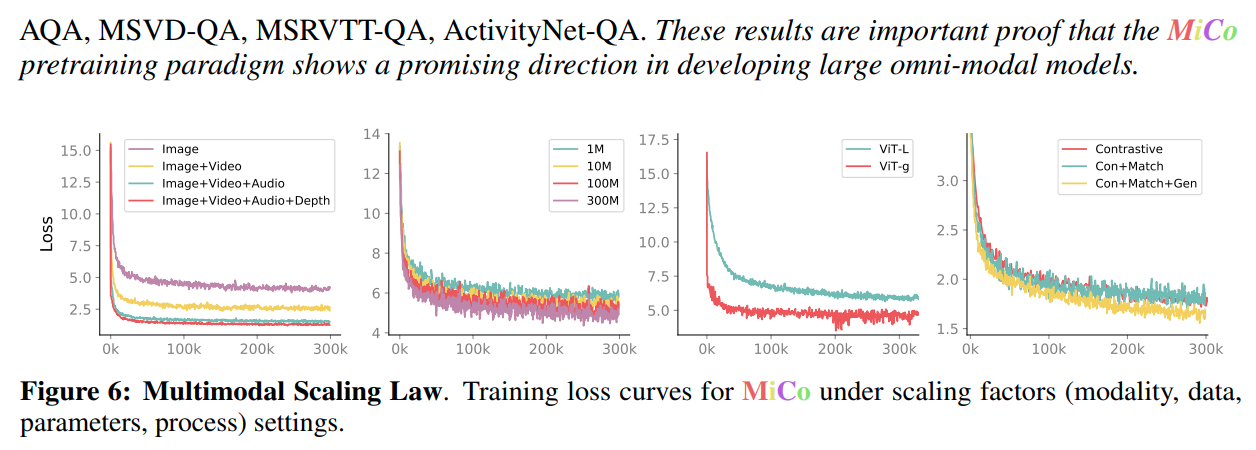

In [ ]:
# your HF token goes here
!huggingface-cli login --token 

In [ ]:
!pip install torch==2.0.1 
!pip install torchvision==0.15.2 
!pip install torchaudio==2.0.2 
!pip install decord 
!pip install h5py 
!pip install ffmpeg-python 
!pip install yacs 
!pip install toolz 
!pip install ipdb 
!pip install einops 
!pip install easydict 
!pip install transformers==4.31.0 
!pip install webdataset 
!pip install SentencePiece
!pip install gdown

In [ ]:
import os
import torch 
import json
import argparse
from tqdm import tqdm 
from collections import defaultdict
import torch.nn.functional as F
from time import time
from easydict import EasyDict as edict

from model.mico import *


def load_from_pretrained_dir(pretrain_dir, video_resolution=224, return_modal="full"):

    checkpoint_dir = os.path.join(pretrain_dir,'ckpt')
    file_cfg = edict(json.load(open(os.path.join(pretrain_dir,'log','hps.json'))))
    model_cfg = file_cfg.model_cfg
    checkpoint_ls = [ i for i in os.listdir(checkpoint_dir) if i.startswith('model_step')]
    checkpoint_ls = [int(i.split('_')[2].split('.')[0]) for i in checkpoint_ls]
    checkpoint_ls.sort()    
    step = checkpoint_ls[-1]
        
    checkpoint_name = 'model_step_'+str(step)+'.pt'
    ckpt_file = os.path.join(checkpoint_dir, checkpoint_name)
    checkpoint = torch.load(ckpt_file, map_location = 'cpu')
    print(f'load_from_pretrained: {ckpt_file}')

    new_ckpt = {}
    for k,v in checkpoint.items():
        if 'video' in k:
            new_ckpt[k.replace('video','vision')]=v
        elif 'evaclip_model' in k:
            new_ckpt[k.replace('evaclip_model','vision_encoder')]=v
        elif 'clip_model' in k:    
            new_ckpt[k.replace('clip_model','vision_encoder')]=v
        else:
            new_ckpt[k] = v.float()
    
    checkpoint = new_ckpt

    if model_cfg.frame_embedding_type == 'adaptive':

        if 'vision_frame_embedding' in checkpoint:
            pretrain_embed = checkpoint['vision_frame_embedding']
            if pretrain_embed.shape[1]!=model_cfg.max_vision_sample_num:
                pretrain_embed = F.interpolate(pretrain_embed.permute(0,2,1),model_cfg.max_vision_sample_num,mode='nearest').permute(0,2,1)
                checkpoint['vision_frame_embedding'] = pretrain_embed
        else: 
            pretrain_embed = checkpoint['vision_perceiver.vision_frame_embedding']
            if pretrain_embed.shape[1]!=model_cfg.max_vision_sample_num:
                pretrain_embed = F.interpolate(pretrain_embed.permute(0,2,1),model_cfg.max_vision_sample_num,mode='nearest').permute(0,2,1)
                checkpoint['vision_perceiver.vision_frame_embedding'] = pretrain_embed

        if 'audio_frame_embedding' in checkpoint:
            pretrain_embed_a = checkpoint['audio_frame_embedding']
            if pretrain_embed_a.shape[1]!=model_cfg.max_audio_sample_num:
                pretrain_embed_a = F.interpolate(pretrain_embed_a.permute(0,2,1),model_cfg.max_audio_sample_num,mode='nearest').permute(0,2,1)
                checkpoint['audio_frame_embedding'] = pretrain_embed_a

    if model_cfg.vision_encoder_type.startswith('clip'):
        vision_width = checkpoint["vision_encoder.visual.positional_embedding"].shape[1]
        vision_layers = len([k for k in checkpoint.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = checkpoint["vision_encoder.visual.conv1.weight"].shape[-1]
        
        grid_size = round((checkpoint["vision_encoder.visual.positional_embedding"].shape[0] - 1) ** 0.5)
    
        src  = checkpoint["vision_encoder.visual.positional_embedding"]
        src_cls = src[0:1]
        src_oth = src[1:]
        new_grid_size = model_cfg.vision_resolution // vision_patch_size
        if new_grid_size!=grid_size:
            src_oth = F.interpolate(src_oth.reshape(grid_size,grid_size,vision_width).permute(2,0,1).unsqueeze(0),(new_grid_size,new_grid_size),mode='bilinear')
            src_oth = src_oth[0].permute(1,2,0).reshape(-1,src.shape[-1])
            tgt = torch.cat((src_cls,src_oth),dim=0)
            checkpoint["vision_encoder.visual.positional_embedding"] = tgt

    elif model_cfg.vision_encoder_type.startswith('evaclip'):

        vision_width = checkpoint["vision_encoder.visual.pos_embed"].shape[2]
        vision_layers = len([k for k in checkpoint.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])

        vision_patch_size = checkpoint["vision_encoder.visual.patch_embed.proj.weight"].shape[-1]
        
        grid_size = round((checkpoint["vision_encoder.visual.pos_embed"].shape[1] - 1) ** 0.5)
    
        src  = checkpoint["vision_encoder.visual.pos_embed"][0]
        src_cls = src[0:1]
        src_oth = src[1:]
        new_grid_size = model_cfg.vision_resolution // vision_patch_size
        if new_grid_size!=grid_size:
            src_oth = F.interpolate(src_oth.reshape(grid_size,grid_size,vision_width).permute(2,0,1).unsqueeze(0),(new_grid_size,new_grid_size),mode='bilinear')
            src_oth = src_oth[0].permute(1,2,0).reshape(-1,src.shape[-1])
            tgt = torch.cat((src_cls,src_oth),dim=0)
            checkpoint["vision_encoder.visual.pos_embed"] = tgt.unsqueeze(0)
    else:
        pass

    if return_modal=="full":
        new_ckpt = checkpoint
    elif return_modal=="uni":
        new_ckpt = defaultdict()
        for k in checkpoint.keys():
            if "video_encoder" in k:
                new_k = ".".join(k.split(".")[1:])
                new_ckpt[new_k] = checkpoint[k]
    elif return_modal=="text":
        new_ckpt = defaultdict()
        for k in checkpoint.keys():
            if "multimodal_encoder" in k:
                new_k = ".".join(k.split(".")[1:])
                new_ckpt[new_k] = checkpoint[k]
    else:
        pass

    return new_ckpt, model_cfg


if __name__ == "__main__":
    # import ipdb
    # ipdb.set_trace()
    device = "cuda"
    from model.imageprocessor import ImageProcessor
    pretrain_path = '/kaggle/working/MiCo-g'
    checkpoint, opts = load_from_pretrained_dir("MiCo-g", video_resolution=224, return_modal="full")
    model = MiCo.from_pretrained(opts,checkpoint).to(device)
    image_file = "/kaggle/working/MiCo/example/test.jpeg"
    proc = ImageProcessor(image_resolution=224, image_encoder_type="swin", training=True)
    image_input = proc(image_file).to(device)
    image_input = image_input.unsqueeze(1) # image as a 1 frame video

    video_output = model.forward_vision_encoder(image_input)
    video_output_pooled = model.pool_vision_for_contra(video_output)
    feat_v = model.contra_head_v(video_output_pooled)
    feat_v = F.normalize(feat_v,dim=-1)

    texts = ["a man is skiing in a snowy day.", "it's a hot day"]
    caption_tokens = model.multimodal_encoder.tokenizer(texts,
                                                    padding="max_length",
                                                    truncation=True,
                                                    max_length=30,
                                                    return_tensors="pt")
    caption_tokens = caption_tokens.to(torch.device('cuda'))
    input_ids = caption_tokens.input_ids
    attention_mask = caption_tokens.attention_mask
    caption_output = model.forward_multimodal_encoder(input_ids, attention_mask).sequence_output
    caption_output_pooled = model.pool_text_for_contra(caption_output)
    feat_t = model.contra_head_t(caption_output_pooled) 
    feat_t = F.normalize(feat_t,dim=-1)


    sim_t2v = torch.matmul(feat_t, feat_v.permute(1,0))
    print(sim_t2v)

    video_input = model.get_multimodal_forward_input_vision(video_output)
    slice_output = model.forward_multimodal_encoder(input_ids, attention_mask, video_input).sequence_output
    slice_scores = F.softmax(model.itm_head(slice_output[:,0]),dim=1)[:,1]
    print(slice_scores)


    video_input = model.get_multimodal_forward_input_vision(video_output)
    init_input_ids = torch.ones(video_input.size(0), 1).long().cuda().fill_(model.multimodal_encoder.tokenizer.bos_token_id)
    init_attention_mask = init_input_ids.new_ones(video_input.size(0), 1, 1)
    outputs = model.multimodal_encoder.generate(input_ids=init_input_ids,
                                                                attention_mask=init_attention_mask,
                                                                encoder_hidden_states=video_input,
                                                                max_new_tokens=model.max_caption_len,
                                                                num_beams=model.beam_size,
                                                                eos_token_id=model.multimodal_encoder.tokenizer.sep_token_id,
                                                                pad_token_id=model.multimodal_encoder.tokenizer.pad_token_id,
                                                                length_penalty=0.6) 
    outputs_newgen = outputs[:,1:]
    captions = model.multimodal_encoder.tokenizer.batch_decode(outputs_newgen, skip_special_tokens=True)
    print(captions)

In [ ]:
import os
import torch 
import json
import argparse
from tqdm import tqdm 
from collections import defaultdict
import torch.nn.functional as F
from time import time
from easydict import EasyDict as edict

from model.mico import *
from model.imageprocessor import ImageProcessor

# def load_from_pretrained_dir(pretrain_dir, video_resolution=224, return_modal="full"):
#     # ... (keep the existing implementation)
#     pass

def debug_forward_vision_encoder(model, image_input):
    print(f"Input shape: {image_input.shape}")
    print(f"Input device: {image_input.device}")
    print(f"Model device: {next(model.parameters()).device}")

    # Handle the unexpected extra dimension
    if len(image_input.shape) == 6:
        print("Detected unexpected 6D input, removing extra dimension")
        image_input = image_input.squeeze(2)
        print(f"New input shape after squeeze: {image_input.shape}")

    b, n, c, h, w = image_input.shape
    print(f"Unpacked dimensions: batch={b}, frames={n}, channels={c}, height={h}, width={w}")

    # Debugging the forward_vision_encoder method
    if model.config.vision_encoder_type.startswith('clip') or model.config.vision_encoder_type.startswith('evaclip'):
        print("Using CLIP or EvaCLIP encoder")
        vision_output = model.vision_encoder.visual(image_input.reshape(b*n, c, h, w), return_all_features=True)
        print(f"Vision output shape: {vision_output.shape}")
        vision_output = vision_output.reshape(b, -1, *vision_output.shape[-2:])
        print(f"Reshaped vision output shape: {vision_output.shape}")
    elif model.config.vision_encoder_type.startswith('swin'):
        print("Using Swin encoder")
        vision_output = model.vision_encoder(image_input.reshape(b*n, c, h, w))
        print(f"Vision output shape: {vision_output.shape}")
        vision_output = vision_output.reshape(b, -1, *vision_output.shape[-2:])
        print(f"Reshaped vision output shape: {vision_output.shape}")
    elif model.config.video_encoder_type.startswith('videoswin'):
        print("Using VideoSwin encoder")
        vision_output = model.vision_encoder(image_input.transpose(1, 2))
        print(f"Vision output shape: {vision_output.shape}")
        vision_output = vision_output.permute(0, 2, 3, 4, 1)
        print(f"Permuted vision output shape: {vision_output.shape}")
        vision_output = vision_output.reshape(b, n, -1, vision_output.shape[-1])
        print(f"Reshaped vision output shape: {vision_output.shape}")
    else:
        raise NotImplementedError("Unsupported vision encoder type")

    return vision_output

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pretrain_path = '/kaggle/working/MiCo-g'
#     checkpoint, opts = load_from_pretrained_dir(pretrain_path, video_resolution=224, return_modal="full")
    model = MiCo.from_pretrained(opts, checkpoint).to(device)
    model.eval()

    image_file = "/kaggle/working/MiCo/example/test.jpeg"
    proc = ImageProcessor(image_resolution=224, image_encoder_type="swin", training=True)
    image_input = proc(image_file).to(device)
    image_input = image_input.unsqueeze(0).unsqueeze(1)  # Add batch and frame dimensions

    print("Debugging forward_vision_encoder:")
    try:
        video_output = debug_forward_vision_encoder(model, image_input)
        print("Forward vision encoder completed successfully")
        print(f"Final output shape: {video_output.shape}")
    except Exception as e:
        print(f"Error in forward_vision_encoder: {str(e)}")
        import traceback
        traceback.print_exc()

    # Continue with the rest of the script only if forward_vision_encoder succeeds
    if 'video_output' in locals():
        try:
            video_output_pooled = model.pool_vision_for_contra(video_output)
            feat_v = model.contra_head_v(video_output_pooled)
            feat_v = F.normalize(feat_v, dim=-1)

            texts = ["a man is skiing in a snowy day.", "it's a hot day"]
            caption_tokens = model.multimodal_encoder.tokenizer(texts,
                                                            padding="max_length",
                                                            truncation=True,
                                                            max_length=30,
                                                            return_tensors="pt")
            caption_tokens = caption_tokens.to(device)
            input_ids = caption_tokens.input_ids
            attention_mask = caption_tokens.attention_mask
            caption_output = model.forward_multimodal_encoder(input_ids, attention_mask).sequence_output
            caption_output_pooled = model.pool_text_for_contra(caption_output)
            feat_t = model.contra_head_t(caption_output_pooled) 
            feat_t = F.normalize(feat_t, dim=-1)

            sim_t2v = torch.matmul(feat_t, feat_v.permute(1,0))
            print("Similarity scores:")
            print(sim_t2v)

            video_input = model.get_multimodal_forward_input_vision(video_output)
            slice_output = model.forward_multimodal_encoder(input_ids, attention_mask, video_input).sequence_output
            slice_scores = F.softmax(model.itm_head(slice_output[:,0]), dim=1)[:,1]
            print("Slice scores:")
            print(slice_scores)

            init_input_ids = torch.ones(video_input.size(0), 1).long().to(device).fill_(model.multimodal_encoder.tokenizer.bos_token_id)
            init_attention_mask = init_input_ids.new_ones(video_input.size(0), 1, 1)
            outputs = model.multimodal_encoder.generate(input_ids=init_input_ids,
                                                        attention_mask=init_attention_mask,
                                                        encoder_hidden_states=video_input,
                                                        max_new_tokens=model.max_caption_len,
                                                        num_beams=model.beam_size,
                                                        eos_token_id=model.multimodal_encoder.tokenizer.sep_token_id,
                                                        pad_token_id=model.multimodal_encoder.tokenizer.pad_token_id,
                                                        length_penalty=0.6) 
            outputs_newgen = outputs[:,1:]
            captions = model.multimodal_encoder.tokenizer.batch_decode(outputs_newgen, skip_special_tokens=True)
            print("Generated captions:")
            print(captions)
        except Exception as e:
            print(f"Error in subsequent processing: {str(e)}")
            import traceback
            traceback.print_exc()
    else:
        print("Skipping subsequent processing due to error in forward_vision_encoder")

In [ ]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from model.mico import MiCo
from model.imageprocessor import ImageProcessor

def load_mico_model(pretrain_path, device):
    checkpoint, opts = load_from_pretrained_dir(pretrain_path, video_resolution=224, return_modal="full")
    model = MiCo.from_pretrained(opts, checkpoint).to(device)
    return model

def process_image_batch(model, image_processor, image_files, device, batch_size=32):
    all_captions = []
    
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]
        batch_inputs = []
        
        for image_file in batch_files:
            image_input = image_processor(image_file).to(device)
            image_input = image_input.unsqueeze(1)  # image as a 1 frame video
            batch_inputs.append(image_input)
        
        batch_inputs = torch.cat(batch_inputs, dim=0)
        
        with torch.no_grad():
            video_output = model.forward_vision_encoder(batch_inputs)
            video_input = model.get_multimodal_forward_input_vision(video_output)
            
            init_input_ids = torch.ones(video_input.size(0), 1).long().to(device).fill_(model.multimodal_encoder.tokenizer.bos_token_id)
            init_attention_mask = init_input_ids.new_ones(video_input.size(0), 1, 1)
            
            outputs = model.multimodal_encoder.generate(
                input_ids=init_input_ids,
                attention_mask=init_attention_mask,
                encoder_hidden_states=video_input,
                max_new_tokens=model.max_caption_len,
                num_beams=model.beam_size,
                eos_token_id=model.multimodal_encoder.tokenizer.sep_token_id,
                pad_token_id=model.multimodal_encoder.tokenizer.pad_token_id,
                length_penalty=0.6
            )
            
            outputs_newgen = outputs[:, 1:]
            batch_captions = model.multimodal_encoder.tokenizer.batch_decode(outputs_newgen, skip_special_tokens=True)
            all_captions.extend(batch_captions)
    
    return all_captions

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     pretrain_path = 'MiCo-g'  # Update this path as needed
    image_dir = '/kaggle/working/MiCo/example'  # Update this to your image directory
    
    # Load model
#     model = load_mico_model(pretrain_path, device)
    
    # Initialize image processor
    image_processor = ImageProcessor(image_resolution=224, image_encoder_type="swin", training=False)
    
    # Get list of image files
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process images in batches
    captions = process_image_batch(model, image_processor, image_files, device)
    
    # Print results
    for image_file, caption in zip(image_files, captions):
        print(f"Image: {image_file}")
        print(f"Caption: {caption}")
        print()

if __name__ == "__main__":
    main()

In [ ]:
import os
import torch
import torch.nn.functional as F
from datasets import load_dataset
from model.mico import MiCo
from model.imageprocessor import ImageProcessor

def load_mico_model(pretrain_path, device):
    checkpoint, opts = load_from_pretrained_dir(pretrain_path, video_resolution=224, return_modal="full")
    model = MiCo.from_pretrained(opts, checkpoint).to(device)
    return model

def process_image(model, transform, image, device):
    # Convert PIL Image to tensor and apply transformations
    image_input = transform(image).unsqueeze(0).to(device)
    image_input = image_input.unsqueeze(1)  # Add frame dimension

    with torch.no_grad():
        video_output = model.forward_vision_encoder(image_input)
        video_input = model.get_multimodal_forward_input_vision(video_output)
        
        init_input_ids = torch.ones(video_input.size(0), 1).long().to(device).fill_(model.multimodal_encoder.tokenizer.bos_token_id)
        init_attention_mask = init_input_ids.new_ones(video_input.size(0), 1, 1)
        
        outputs = model.multimodal_encoder.generate(
            input_ids=init_input_ids,
            attention_mask=init_attention_mask,
            encoder_hidden_states=video_input,
            max_new_tokens=model.max_caption_len,
            num_beams=model.beam_size,
            eos_token_id=model.multimodal_encoder.tokenizer.sep_token_id,
            pad_token_id=model.multimodal_encoder.tokenizer.pad_token_id,
            length_penalty=0.6
        )
        
        outputs_newgen = outputs[:, 1:]
        caption = model.multimodal_encoder.tokenizer.decode(outputs_newgen[0], skip_special_tokens=True)
    
    return caption

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pretrain_path = 'MiCo-g'  # Update this path as needed
    dataset_name = "tinycrops/my_image_dataset"
    
    # Load model
    model = load_mico_model(pretrain_path, device)
    
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the dataset
    dataset = load_dataset(dataset_name, split="train")
    
    # Process the first image in the dataset
    if len(dataset) > 0:
        image = dataset[0]['image']
        file_name = dataset[0]['file_name']
        
        caption = process_image(model, transform, image, device)
        
        print(f"Image: {file_name}")
        print(f"Generated Caption: {caption}")
    else:
        print("No images found in the dataset.")

if __name__ == "__main__":
    main()

In [ ]:
import os
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from model.mico import MiCo
from model.imageprocessor import ImageProcessor
from tqdm import tqdm
from torchvision import transforms

def load_mico_model(pretrain_path, device):
    checkpoint, opts = load_from_pretrained_dir(pretrain_path, video_resolution=224, return_modal="full")
    model = MiCo.from_pretrained(opts, checkpoint).to(device)
    return model

def process_image(model, transform, image, device):
    # Convert PIL Image to tensor and apply transformations
    image_input = transform(image).unsqueeze(0).to(device)
    image_input = image_input.unsqueeze(1)  # Add frame dimension

    with torch.no_grad():
        video_output = model.forward_vision_encoder(image_input)
        video_input = model.get_multimodal_forward_input_vision(video_output)
        
        init_input_ids = torch.ones(video_input.size(0), 1).long().to(device).fill_(model.multimodal_encoder.tokenizer.bos_token_id)
        init_attention_mask = init_input_ids.new_ones(video_input.size(0), 1, 1)
        
        outputs = model.multimodal_encoder.generate(
            input_ids=init_input_ids,
            attention_mask=init_attention_mask,
            encoder_hidden_states=video_input,
            max_new_tokens=model.max_caption_len,
            num_beams=model.beam_size,
            eos_token_id=model.multimodal_encoder.tokenizer.sep_token_id,
            pad_token_id=model.multimodal_encoder.tokenizer.pad_token_id,
            length_penalty=0.6
        )
        
        outputs_newgen = outputs[:, 1:]
        caption = model.multimodal_encoder.tokenizer.decode(outputs_newgen[0], skip_special_tokens=True)
    
    return caption

def process_dataset(model, transform, dataset, device):
    captions = []
    for item in tqdm(dataset, desc="Processing images"):
        image = item['image']
        caption = process_image(model, transform, image, device)
        captions.append(caption)
    return captions

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pretrain_path = 'MiCo-g'  # Update this path as needed
    input_dataset_name = "tinycrops/my_image_dataset"
    output_dataset_name = "tinycrops/my_image_dataset_with_captions"
    
    # Load model
    model = load_mico_model(pretrain_path, device)
    
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the dataset
    dataset = load_dataset(input_dataset_name, split="train")
    
    # Process all images in the dataset
    captions = process_dataset(model, transform, dataset, device)
    
    # Add captions to the dataset
    dataset = dataset.add_column("caption", captions)
    
    # Upload the updated dataset to HuggingFace
    dataset.push_to_hub(output_dataset_name)
    
    print(f"Processing complete. Updated dataset uploaded to {output_dataset_name}")

if __name__ == "__main__":
    main()